# Text Classification  -  Sentiment Analysis

##  Load required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

from time import time
from sklearn import metrics

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


## Load and prepare the data

### Load the data

In [2]:
# load the data
data = pd.read_csv("redoute_v3.csv")

# data of interest are "rating" and "comment"
df = data[["rating", "comment"]]
df.head()

#check NaN values
print(df.isna().sum())


rating     0
comment    0
dtype: int64


### Prepare the data
We use NLTK to process the comment's text : 
- remove punctuation,
- remove numeric characters,
- remove stopwords

#### Clean the comment's text

In [3]:
# Clean comments : remove number, punctuation, keep only alphabetic string chains word length >= 2
# remove stop words
# and convert to lower case

#non_discrimant_words = ["redoute", "commande", "redoute", "achat","livraison", "article", "articles", "produit", "produits"]
added_stopwords = ["être", "leur", "leurs", "avoir", "cela", "les", "de", "pour", "des", "cette", "a",
                   "j'ai", "car", "c'est", "chez", "tout", "fait", "chez", "donc", 
                   "n'est", "si", "alors", "n'ai", "faire", "deux", "comme", "jour", "tr", "si", "ue"]
stop_words = set(stopwords.words('french'))  | set(added_stopwords) #| set(non_discrimant_words)

def clean_text(txt):
    #keep only alphabetic string with lenght >= 2
    #tokenizer = RegexpTokenizer(r"[a-zA-Zàéèêëôùûüiîï'-!?]{2,}")
    tokenizer = RegexpTokenizer(r"[a-zA-Zàéèêëôùûüiîï'\-!?]{2,}")
    tokens = tokenizer.tokenize(txt.lower())
    txt_cleaned = ""
    for mot in tokens:
        #filter stopwords
        if mot not in stop_words:
            txt_cleaned = txt_cleaned + mot + " "
    return txt_cleaned

# clean all comments
data["comment_cleaned"] = data["comment"].apply(clean_text)


####  Clean and lemmatize comment's text

In [4]:
# function to lemmatize a text with spacy
import spacy 
nlp = spacy.load('fr_core_news_md')

# lemmatized all comments
def clean_text_lemmatize(txt):
    #keep only alphabetic string with lenght >= 2
    tokens = nlp(clean_text(txt))  
    txt_lemmatized = ""
    for token in tokens:
        #filter stopwords
        if token not in stop_words:
            #French leammatization with spacy
            txt_lemmatized =  txt_lemmatized + token.lemma_ + " "
    return txt_lemmatized

data["comment_lemmatized"] = data["comment"].apply(clean_text_lemmatize)

### CloudWords

In [5]:
from wordcloud import WordCloud
from PIL import Image

def plot_word_cloud(text, title, background_color = "white"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    #plt.figure(figsize= (8,6))
    wc.generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.show()

def generate_word_cloud(text, background_color = "white"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    #plt.figure(figsize= (8,6))
    wc.generate(text)
    return wc
    

In [6]:
#Prepare the comments to be view as a wordCloud
# comments cleaned only
all_comments = ' '.join(data["comment_cleaned"])
cmt4plus = ' '.join(data[data["rating"]>=4]["comment_cleaned"])
cmt3 = ' '.join(data[data["rating"]==3]["comment_cleaned"])
cmt2minus = ' '.join(data[data["rating"]<=2]["comment_cleaned"])

#comments cleaned and lemmatized
all_comments_lem = ' '.join(data["comment_lemmatized"])
cmt4plus_lem = ' '.join(data[data["rating"]>=4]["comment_lemmatized"])
cmt3_lem = ' '.join(data[data["rating"]==3]["comment_lemmatized"])
cmt2minus_lem = ' '.join(data[data["rating"]<=2]["comment_lemmatized"])

# list of text for the wordcloud 
all_cmt_list = [ (all_comments, all_comments_lem, "all_comments", "all_comments_lem", "white"), 
                (cmt4plus, cmt4plus_lem, "cmt4plus", "cmt4plus_lem", "rosybrown"), #"saddlebrown"),
                (cmt3, cmt3_lem, "cmt3", "cmt3_lem", "navy"), 
                (cmt2minus, cmt2minus_lem, "cmt2minus", "cmt2minus_lem", "black")]

#all_cmt_list = [ (all_comments, all_comments_lem), (cmt4plus, cmt4plus_lem), (cmt3, cmt3_lem), (cmt2minus, cmt2minus_lem)]

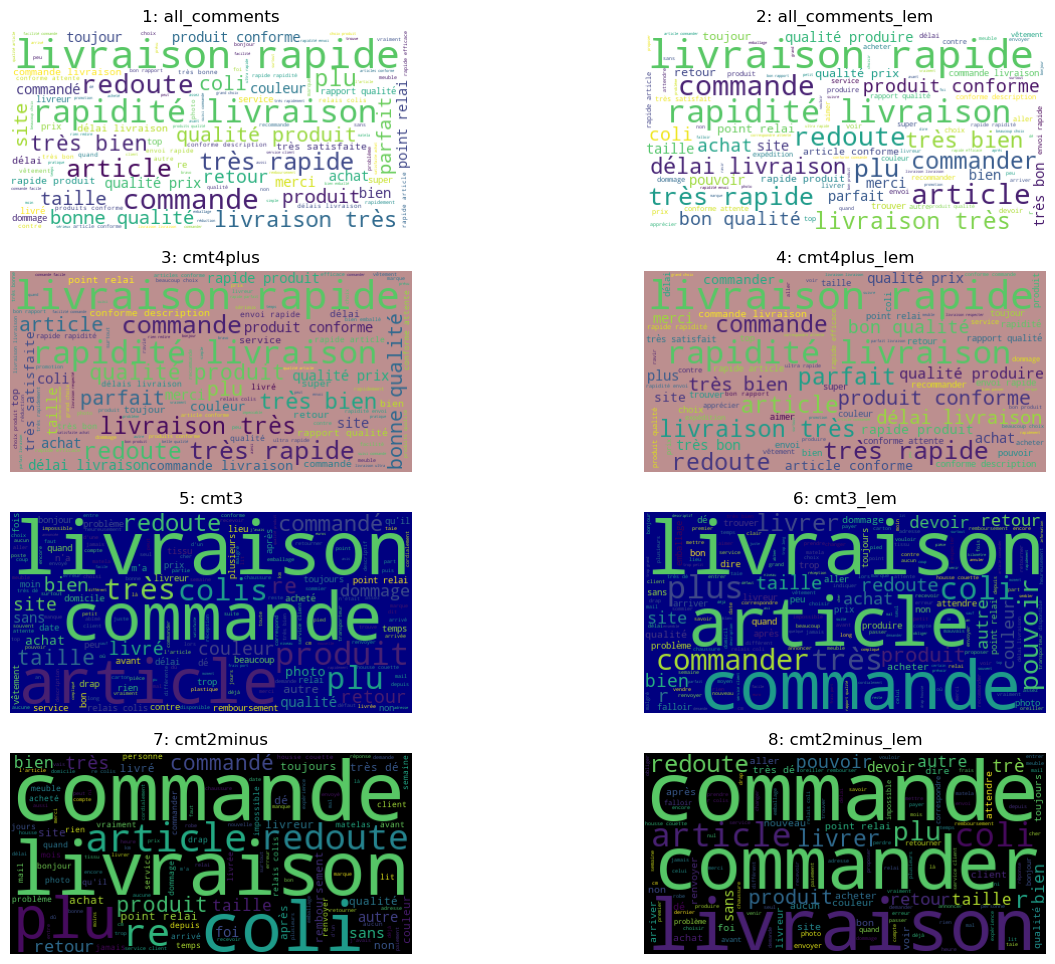

In [7]:
fig = plt.figure(figsize = (15, 12))
j = 1
bcolor = "white"
for cmt, cmt_lem, cmt_title, cmt_lem_title, bcolor in all_cmt_list:
    ax = fig.add_subplot(4,2,j)
    wc = generate_word_cloud(cmt, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j) + ": " + cmt_title)
    ax.axis('off')

    ax = fig.add_subplot(4,2,j+1)
    wc = generate_word_cloud(cmt_lem, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j+1) + ": " + cmt_lem_title)
    ax.axis('off')
    j = j+2

## II - Split data into training and test data
- Set the test size at 25% of the overall sample.
- Set stratify = y to preserve the repartition of labels on training and test data

In [9]:
# the target variable is 1 if rating <= 3 and 0 if rating >= 4
y = (data["rating"]<=3)*1  

# explanatory variable
X = data["comment_cleaned"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)

print("label repartition:\n", y.value_counts(normalize = True))
print("label repartition on train data:\n", y_train.value_counts(normalize = True))
print("label repartition on test data:\n", y_test.value_counts(normalize = True))


label repartition:
 rating
0    0.884955
1    0.115045
Name: proportion, dtype: float64
label repartition on train data:
 rating
0    0.88495
1    0.11505
Name: proportion, dtype: float64
label repartition on test data:
 rating
0    0.884969
1    0.115031
Name: proportion, dtype: float64


## III - Preprocessing 
### III.1 - Preprocessing with TF-IDF
- TF-IDF
- RandomUnderSampling

In [10]:
#vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)
vectorizer = TfidfVectorizer()

V_train = vectorizer.fit_transform(X_train)
V_test = vectorizer.transform(X_test)

# Undersampling to take class imbalance into account
ru = RandomUnderSampler()
V_ru, y_ru = ru.fit_resample(V_train, y_train)


In [21]:
print(V_ru.shape)
print(y_ru.shape)

(4050, 9695)
(4050,)


### III.2 - Preprocessing with CountVectorizer
- CountVectorizer
- RandomUnderSampling

In [22]:
#vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)

#Vectorisation du texte
vectorizer = CountVectorizer()
V_train_cvz = np.asarray(vectorizer.fit_transform(X_train).todense())
V_test_cvz = np.asarray(vectorizer.transform(X_test).todense())

# Undersampling to take class imbalance into account
ru = RandomUnderSampler()
V_ru_cvz, y_ru_cvz = ru.fit_resample(V_train_cvz, y_train)

In [29]:
print(V_ru_cvz.shape)
print(y_ru_cvz.shape)

(4050, 9695)
(4050,)


array([0, 0, 0, ..., 0, 0, 0])

## IV - Functions to fit and evaluate a model, to visualize model's metrics

### IV.1 - Function to fit and evaluate a model

In [30]:
# function to fit a model and calculate its metrics and time performance

def fit_and_evaluate(model_name, model, encoder=0):
    """ function to fit a model and calculate its metrics and time performance
        return a dataFrame of metrics and time performance
        encoder = 0  => fit on X_train, y_train without undersampling
        encoder = 1 => fit on random undersampled TfIdfVectorize train data
        encoder = 2 ==> fit on random undersamled CountVectorized train data
    """
    # Fit the model to the training data
    t0 = time()
    if encoder == 0:
        model.fit(X_train, y_train) # model fit directy on original X_train, y_train. To be used with pipeline
    elif encoder == 1:
        model.fit(V_ru, y_ru)  # model fit on the under-sampled tf-idf vectorized train data
    elif encoder == 2:
        model.fit(V_ru_cvz, y_ru_cvz)  # model fit on the under-sampled CountVectorized train data
    else:
        raise ValueError("Admissible values for encoder are 0, 1 or 2")
    t1 = time()
    
    # Prediction on the tf-idf vectorized test data
    if encoder == 0: 
        prediction = model.predict(X_test) 
    else:
        prediction = model.predict(V_test) 
   
    t2 = time()
    time_train = t1-t0
    time_predict = t2-t1

    # Evaluate model performance
    if encoder == 0: 
        accuracy = model.score(X_test, y_test)
    else:
        accuracy = model.score(V_test, y_test)
        
    f1_score = metrics.f1_score(y_test, prediction)
    recall = metrics.recall_score(y_test, prediction)
    precision = metrics.precision_score(y_test, prediction)
    
    classif_rep = metrics.classification_report(y_test, prediction)
    confusion_mx = pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"])
    
    #print("TF-IDF / Results for {}".format(model_name))
    #print("Training time: %fs; Prediction time: %fs" % (time_train, time_predict))
    #print(metrics.classification_report(y_test, prediction))
    #display(pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"]))

    classif_rep = metrics.classification_report(y_test, prediction)
    confusion_mx = pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"])
    res = {"model": model_name, "time_train":time_train, "time_predict": time_predict,
           "accuracy": accuracy, "f1_score": f1_score, "recall": recall, "precision" : precision }
    df_p = pd.DataFrame(res, index=[0])

    return (df_p, classif_rep, confusion_mx)
    

### IV.2 - Function to visualize model metrics

In [31]:
#plot metrics of the models
def plot_metrics(df, title): 
    data_metrics = df.iloc[:,3:]
    data_time = df.iloc[:,:3]
        
    sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})
    fig, ax1 = plt.subplots()
    #fig = plt.figure(figsize=(10,10))
    # plot metrics
    color = 'tab:blue'
    sns.lineplot(data = data_metrics, dashes = True, marker='D', ax = ax1)
    ax1.set_xticks(np.arange(len(models_list)), list(df["model"].values), rotation = 90)
    ax1.set_yticks(np.linspace(0,1,11))
    ax1.set_ylabel("Metric value", color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 0.85), fontsize = 9)
    ax1.set_title(title)

    # plot processing time perfomance on the same figure but with a different scale
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    sns.lineplot(data = data_time, marker='o', ax = ax2, palette = "dark:#5A9_r")
    ax2.set_ylabel("Time", color = color)
    ax2.set_ylabel("Time", color = color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3, 0.3), fontsize = 9)
  
    plt.show()

## V - Models
- SVM, MultinomialNB, Logistitics Regression, Decision Trees, KNN, Gradient Boost models

### V.1 TF-IDF

#### V.1.1 - fit models and evaluate

In [32]:
# list of models to train and evaluate
models_list = [("LinearSVC", svm.LinearSVC()),
              ("SVC(kernel=linear)", svm.SVC(kernel='linear')),
              ("SVC(kernel=rbf)", svm.SVC()),
              ("MultinomialNB", MultinomialNB()),
              #("GaussianNB", GaussianNB()),
              ("Log_reg_lbfgs", LogisticRegression(solver = "lbfgs")),
              ("Log_reg_liblinear", LogisticRegression(solver = "liblinear")),
              ("Log_reg_newton_cg", LogisticRegression(solver = "newton-cg")),
              ("Log_reg_sag", LogisticRegression(solver = "sag")),
              ("Log_reg_saga", LogisticRegression(solver = "saga")),
              ("decision_tree", DecisionTreeClassifier()),
              ("KNN", KNeighborsClassifier(n_neighbors=4, weights="uniform")),
              ("Gradient Boosting Classifier", GradientBoostingClassifier())]

#train and evaluate the models after tf-idf transformation
list_of_models = []
confusion_mx = []
classif_rep = []
df_perf = pd.DataFrame([])

for (model_name, model) in models_list:    
    (df0, clrep, cfmx)  = fit_and_evaluate(model_name, model, encoder=1)
    list_of_models.append(model_name)
    df_perf = pd.concat([df_perf, df0])
    classif_rep.append(clrep)
    confusion_mx.append(cfmx)

df_perf = df_perf.reset_index().drop("index", axis = 1)   


In [33]:
#function to visualize confusion matrix side by side
from IPython.core.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

from IPython.core.display import display, HTML

display_side_by_side(confusion_mx, list_of_models)
    


#### V.1.2 Visualize model performance

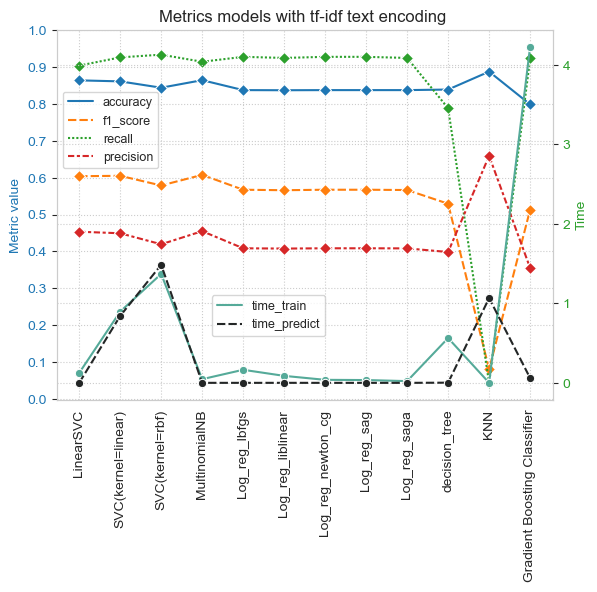

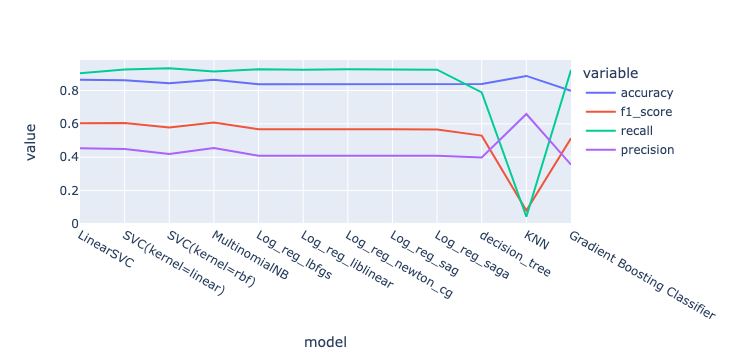

In [34]:
title = "Metrics models with tf-idf text encoding "
plot_metrics(df_perf, title)

# Visualiation with ploty
cols = list(df_perf.iloc[:,3:].columns)
px.line(df_perf, x = "model", y = cols)

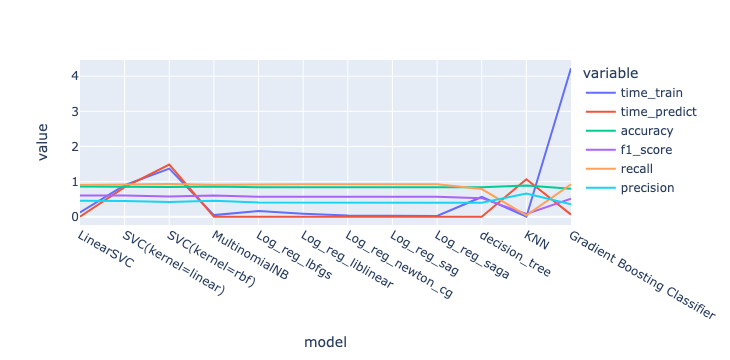

In [35]:
# performance with ploty
cols = list(df_perf.iloc[:,1:].columns)
px.line(df_perf, x = "model", y = cols)

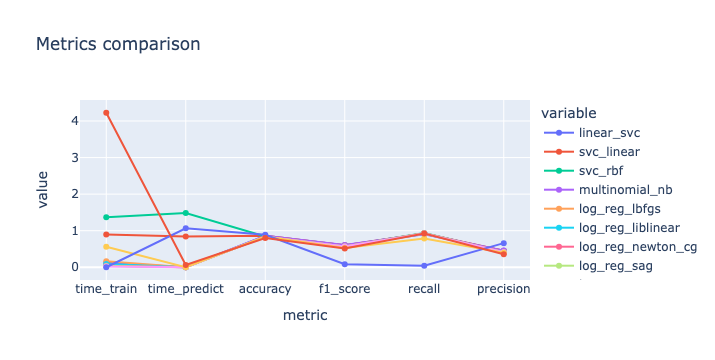

In [36]:
tf = df_perf.T.reset_index()
tf.columns = ["metric","linear_svc", "svc_linear", "svc_rbf",	"multinomial_nb",	"log_reg_lbfgs", "log_reg_liblinear", 
              "log_reg_newton_cg", "log_reg_sag", "log_reg_saga", "decision_tree", "knn", "gradient_boost"]
tf = tf.iloc[1:,:]

# plot 
px.line(tf, x = "metric", y = tf.columns[1:], markers = True, title = "Metrics comparison")


### V.2 - CounterVectorize

#### V.2.1 - Model fit and evaluation

In [37]:
models_list = [("LinearSVC", svm.LinearSVC()),
              #("SVC(kernel=linear)", svm.SVC(kernel='linear')),
              #("SVC(kernel=rbf)",svm.SVC()),   #too long to fit with CountVectorizer
              ("MultinomialNB", MultinomialNB()),
              ("Log_reg_lbfgs", LogisticRegression(solver = "lbfgs")),
              ("Log_reg_liblinear", LogisticRegression(solver = "liblinear")),
              ("Log_reg_newton_cg", LogisticRegression(solver = "newton-cg")),
              ("Log_reg_sag", LogisticRegression(solver = "sag")),
              ("Log_reg_saga", LogisticRegression(solver = "saga")),
              ("decision_tree", DecisionTreeClassifier()),
              ("KNN", KNeighborsClassifier(n_neighbors=4, weights="uniform")),
              #("Gradient Boosting Classifier", GradientBoostingClassifier()), #too long to fit with CountVectorizer
              ]

#fit and evaluate  models after CountVectorization transformation
list_of_models_cvz = []
confusion_mx_cvz = []
classif_rep_cvz = []
df_perf_cvz = pd.DataFrame([])

for (model_name, model) in models_list:    
    (df0, clrep, cfmx)  = fit_and_evaluate(model_name, model, encoder=2)
    list_of_models_cvz.append(model_name)
    df_perf_cvz = pd.concat([df_perf_cvz, df0])
    classif_rep_cvz.append(clrep)
    confusion_mx_cvz.append(cfmx)

df_perf_cvz = df_perf_cvz.reset_index().drop("index", axis = 1)   

#### V.2.2 - Visualize model performance

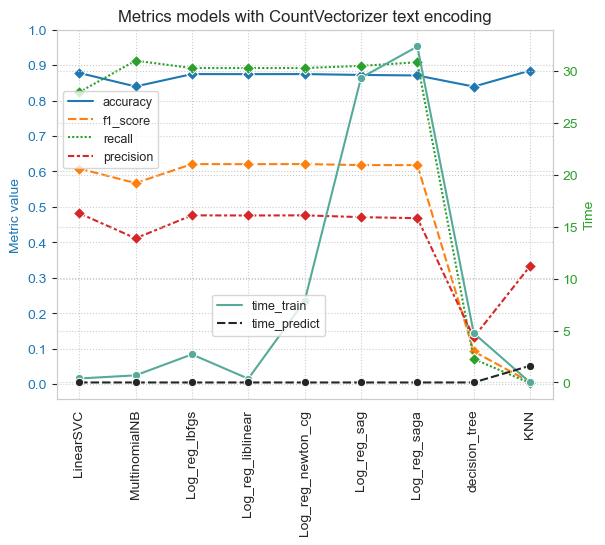

In [38]:
title = "Metrics models with CountVectorizer text encoding"
plot_metrics(df_perf_cvz, title)

In [39]:
tf = df_perf_cvz.T.reset_index()
tf.columns = ["metric","linear_svc", "multinomial_nb",	"log_reg_lbfgs", "log_reg_liblinear", 
              "log_reg_newton_cg", "log_reg_sag", "log_reg_saga", "decision_tree", "knn"]
tf = tf.iloc[1:,:]

# plot 
px.line(tf, x = "metric", y = tf.columns[1:], markers = True, title = "Metrics comparison")


### V.3 - Find best hyperparameters with GridSearchCV for better metrics values

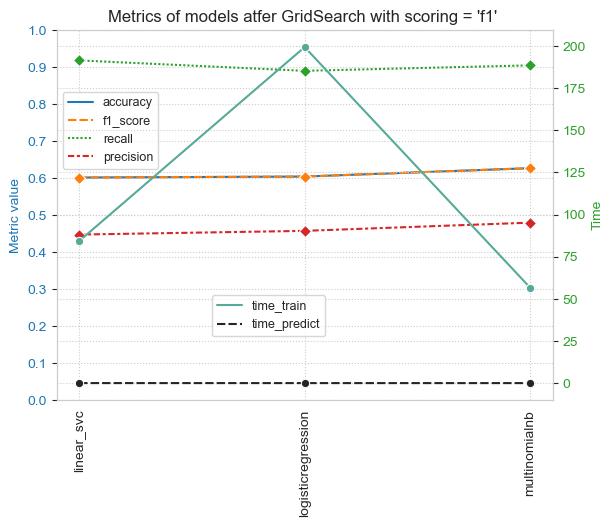

In [40]:
from imblearn.pipeline import make_pipeline

pipe_lsvc = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), svm.LinearSVC())
pipe_lreg = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), LogisticRegression())
pipe_mnnb = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())

params_lsvc = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "linearsvc__C": [0.01, 0.5, 1, 50]     
}

params_lreg = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "logisticregression__C": [0.0001, 0.001, 0.01, 1, 10],
            "logisticregression__solver": ["lbfgs", "liblinear"]  
}

params_mnnb = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "multinomialnb__alpha": [0.5, 0.8, 1]
}

grid_lsvc = GridSearchCV(estimator = pipe_lsvc, param_grid = params_lsvc, scoring = "f1", cv = 5)
grid_lreg = GridSearchCV(estimator = pipe_lreg , param_grid = params_lreg, scoring = "f1", cv = 5)
grid_mnnb = GridSearchCV(estimator = pipe_mnnb , param_grid = params_mnnb, scoring = "f1", cv = 5)

# models to fil and evaluate
models_list = [("linear_svc", grid_lsvc), 
               ("logisticregression", grid_lreg), 
               ("multinomialnb", grid_mnnb)]

#train and evaluate models in models_list
#train and evaluate the models after tf-idf transformation
list_of_models_pipe = []
confusion_mx_pipe = []
classif_rep_pipe = []
df_pipe = pd.DataFrame([])
for (model_name, model) in models_list:    
    (df0, clrep, cfmx)  = fit_and_evaluate(model_name, model, encoder=0)
    list_of_models_pipe.append(model_name)
    df_pipe = pd.concat([df_pipe, df0])
    classif_rep_pipe.append(clrep)
    confusion_mx_pipe.append(cfmx)

df_pipe = df_pipe.reset_index().drop("index", axis = 1)   

plot_metrics(df_pipe, "Metrics of models atfer GridSearch with scoring = 'f1' ")

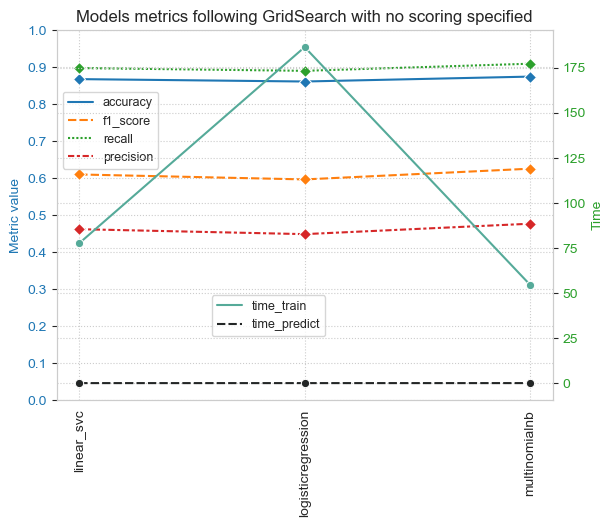

In [44]:
# GridSearchCV with scoring unspecified"
grid_lsvc = GridSearchCV(estimator = pipe_lsvc, param_grid = params_lsvc, cv = 5)
grid_lreg = GridSearchCV(estimator = pipe_lreg , param_grid = params_lreg, cv = 5)
grid_mnnb = GridSearchCV(estimator = pipe_mnnb , param_grid = params_mnnb, cv = 5)

# models to fil and evaluate
models_list = [("linear_svc", grid_lsvc), 
               ("logisticregression", grid_lreg), 
               ("multinomialnb", grid_mnnb)]

#train and evaluate models in models_list
list_of_models_pipe = []
confusion_mx_pipe = []
classif_rep_pipe = []
df_pipe = pd.DataFrame([])
for (model_name, model) in models_list:    
    (df0, clrep, cfmx)  = fit_and_evaluate(model_name, model, encoder=0)
    list_of_models_pipe.append(model_name)
    df_pipe = pd.concat([df_pipe, df0])
    classif_rep_pipe.append(clrep)
    confusion_mx_pipe.append(cfmx)

df_pipe = df_pipe.reset_index().drop("index", axis = 1)   

# Visualize metrics et time performance
plot_metrics(df_pipe, "Models metrics following GridSearch with no scoring specified")

In [43]:
df_pipe = df_pipe.reset_index().drop("index", axis = 1)   

df_pipe

model  time_train  time_predict  accuracy  f1_score    recall  \
0          linear_svc   84.325989      0.059627  0.601650  0.601650  0.918519   
1  logisticregression  199.353069      0.052617  0.604324  0.604324  0.890370   
2       multinomialnb   56.684462      0.050515  0.626988  0.626988  0.905185   
3          linear_svc   83.265781      0.054492  0.861452  0.597724  0.894815   
4  logisticregression  193.615242      0.053419  0.861111  0.600686  0.908148   
5       multinomialnb   55.717975      0.055013  0.872870  0.621704  0.908148   

   precision  
0   0.447330  
1   0.457382  
2   0.479592  
3   0.448737  
4   0.448755  
5   0.472629

## Sentiment Analysis with TextBlob

In [ ]:
## setup
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [ ]:
# function to evaluate the sentiment of a text txt with textblob
def eval_sentiment(txt):
    x = tb(txt).sentiment[0]
    if ( x > 0):
        return "Positif"
    elif ( x < 0):
        return "Negatif"
    else:
        return "Neutre"

In [ ]:
# Evaluate sentiment for all comments
df.loc[:,"sentiment"] = df["comment_cleaned"].apply(eval_sentiment)
df.head()

In [ ]:
df.iloc[3,2]

In [ ]:
# plot the distribution of "sentiment"
sns.countplot(data = df, x = "sentiment")
plt.title("Repartition of Positive, Neutral and Negative sentiments")
plt.show()
sns.countplot(data = df, x = "rating", hue = "sentiment")
plt.title("Repartition of Positive, Neutral and Negative sentiments verus rating")
plt.show()

In [ ]:
#df1 = df[(df["rating"]<=2) & (df["sentiment"]== "Positif")]
#df1.iloc[0,1]

In [ ]:
# Evolution of sentiment over time
data["sentiment"] = df.loc[:, "sentiment"]

In [ ]:
data.head()
d = (data.groupby(["month_of_cmt","sentiment"])["sentiment"].count()).to_frame(name = "sentiment_count")
d = d.reset_index()
plt.figure(figsize=(10,8))
sns.lineplot(data = d, x = "month_of_cmt", y = "sentiment_count", hue = "sentiment", palette = "pastel")
plt.ylabel("Number of reviews")
plt.title("Reviews per day, per sentiment")
#plt.xticks([])
plt.show()

In [ ]:
data.head()
d = (data.groupby(["month_of_cmt","sentiment"])["sentiment"].count()).to_frame(name = "sentiment_count")
d = d.reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data = d, x = "month_of_cmt", y = "sentiment_count", hue = "sentiment", palette = "pastel")
plt.ylabel("Number of reviews")
plt.title("Reviews per month, per sentiment")
#plt.xticks([])
plt.show()

## Rating prediction with Dense Neural Network

In [45]:
y_ru = np.asarray(y_ru).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [80]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(9695,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=512)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))

Epoch 1/20
8/8 [==============================] - 1s 6ms/step - loss: 0.6891 - accuracy: 0.6573
Epoch 2/20
8/8 [==============================] - 0s 7ms/step - loss: 0.6682 - accuracy: 0.8390
Epoch 3/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6344 - accuracy: 0.8822
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 0.5889 - accuracy: 0.9049
Epoch 5/20
8/8 [==============================] - 0s 6ms/step - loss: 0.5334 - accuracy: 0.9183
Epoch 6/20
8/8 [==============================] - 0s 5ms/step - loss: 0.4703 - accuracy: 0.9306
Epoch 7/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4041 - accuracy: 0.9410
Epoch 8/20
8/8 [==============================] - 0s 5ms/step - loss: 0.3405 - accuracy: 0.9494
Epoch 9/20
8/8 [==============================] - 0s 5ms/step - loss: 0.2830 - accuracy: 0.9546
Epoch 10/20
8/8 [==============================] - 0s 7ms/step - loss: 0.2345 - accuracy: 0.9593
Epoch 11/20
8/8 [======================

prediction     0    1
real                 
0.0         4533  660
1.0           68  607

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      5193
         1.0       0.48      0.90      0.63       675

    accuracy                           0.88      5868
   macro avg       0.73      0.89      0.78      5868
weighted avg       0.93      0.88      0.89      5868



In [83]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(9695,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=512)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))


Epoch 1/20
8/8 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.5936
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6732 - accuracy: 0.8546
Epoch 3/20
8/8 [==============================] - 0s 5ms/step - loss: 0.6457 - accuracy: 0.9057
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 0.6076 - accuracy: 0.9264
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 0.5584 - accuracy: 0.9390
Epoch 6/20
8/8 [==============================] - 0s 8ms/step - loss: 0.4982 - accuracy: 0.9469
Epoch 7/20
8/8 [==============================] - 0s 6ms/step - loss: 0.4277 - accuracy: 0.9528
Epoch 8/20
8/8 [==============================] - 0s 5ms/step - loss: 0.3526 - accuracy: 0.9583
Epoch 9/20
8/8 [==============================] - 0s 5ms/step - loss: 0.2808 - accuracy: 0.9620
Epoch 10/20
8/8 [==============================] - 0s 15ms/step - loss: 0.2200 - accuracy: 0.9654
Epoch 11/20
8/8 [=====================

prediction     0    1
real                 
0.0         4545  648
1.0           79  596

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      5193
         1.0       0.48      0.88      0.62       675

    accuracy                           0.88      5868
   macro avg       0.73      0.88      0.77      5868
weighted avg       0.92      0.88      0.89      5868



In [105]:
model = models.Sequential()
model.add(layers.Dense(64, activation='tanh', input_shape=(9695,)))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=405)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))


Epoch 1/20
10/10 [==============================] - 1s 9ms/step - loss: 0.6570 - accuracy: 0.7358
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.5114 - accuracy: 0.9072
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.3411 - accuracy: 0.9198
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.2212 - accuracy: 0.9368
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.1560 - accuracy: 0.9519
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.1146 - accuracy: 0.9664
Epoch 7/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0878 - accuracy: 0.9770
Epoch 8/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0698 - accuracy: 0.9847
Epoch 9/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0575 - accuracy: 0.9881
Epoch 10/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0487 - accuracy: 0.9906
Epoch 11/20
10/10 

prediction     0    1
real                 
0.0         4467  726
1.0           91  584

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92      5193
         1.0       0.45      0.87      0.59       675

    accuracy                           0.86      5868
   macro avg       0.71      0.86      0.75      5868
weighted avg       0.92      0.86      0.88      5868



In [109]:
model = models.Sequential()
model.add(layers.Dense(16, activation='softsign', input_shape=(9695,)))
model.add(layers.Dense(16, activation='softsign'))
model.add(layers.Dense(16, activation='softsign'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=405)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))


Epoch 1/20
10/10 [==============================] - 1s 4ms/step - loss: 0.6785 - accuracy: 0.6684
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.6355 - accuracy: 0.8699
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.5813 - accuracy: 0.8820
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.5212 - accuracy: 0.8985
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4620 - accuracy: 0.9059
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.9158
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3584 - accuracy: 0.9220
Epoch 8/20
10/10 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.9319
Epoch 9/20
10/10 [==============================] - 0s 3ms/step - loss: 0.2774 - accuracy: 0.9393
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 0.2446 - accuracy: 0.9440
Epoch 11/20
10/10 [

prediction     0    1
real                 
0.0         4595  598
1.0           73  602

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      5193
         1.0       0.50      0.89      0.64       675

    accuracy                           0.89      5868
   macro avg       0.74      0.89      0.79      5868
weighted avg       0.93      0.89      0.90      5868



In [116]:
model = models.Sequential()
model.add(layers.Dense(64, activation='selu', input_shape=(9695,)))
model.add(layers.Dense(64, activation='selu'))
#model.add(layers.Dense(16, activation='selu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=405)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))


Epoch 1/20
10/10 [==============================] - 1s 5ms/step - loss: 0.6373 - accuracy: 0.7501
Epoch 2/20
10/10 [==============================] - 0s 6ms/step - loss: 0.4564 - accuracy: 0.8844
Epoch 3/20
10/10 [==============================] - 0s 5ms/step - loss: 0.3176 - accuracy: 0.9123
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 0.2366 - accuracy: 0.9331
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 0.1863 - accuracy: 0.9479
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.1473 - accuracy: 0.9632
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.1206 - accuracy: 0.9691
Epoch 8/20
10/10 [==============================] - 0s 6ms/step - loss: 0.0983 - accuracy: 0.9756
Epoch 9/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9817
Epoch 10/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0700 - accuracy: 0.9862
Epoch 11/20
10/10 [

prediction     0    1
real                 
0.0         4596  597
1.0          108  567

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      5193
         1.0       0.49      0.84      0.62       675

    accuracy                           0.88      5868
   macro avg       0.73      0.86      0.77      5868
weighted avg       0.92      0.88      0.89      5868



In [118]:
model = models.Sequential()
model.add(layers.Dense(16, activation='elu', input_shape=(9695,)))
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=405)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))


Epoch 1/20
10/10 [==============================] - 1s 4ms/step - loss: 0.6708 - accuracy: 0.7160
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.6062 - accuracy: 0.8701
Epoch 3/20
10/10 [==============================] - 0s 3ms/step - loss: 0.5275 - accuracy: 0.8849
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4462 - accuracy: 0.8965
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.3738 - accuracy: 0.9079
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3137 - accuracy: 0.9205
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.2653 - accuracy: 0.9294
Epoch 8/20
10/10 [==============================] - 0s 3ms/step - loss: 0.2268 - accuracy: 0.9370
Epoch 9/20
10/10 [==============================] - 0s 3ms/step - loss: 0.1951 - accuracy: 0.9447
Epoch 10/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9531
Epoch 11/20
10/10 [

prediction     0    1
real                 
0.0         4571  622
1.0           79  596

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      5193
         1.0       0.49      0.88      0.63       675

    accuracy                           0.88      5868
   macro avg       0.74      0.88      0.78      5868
weighted avg       0.93      0.88      0.89      5868



In [119]:
model = models.Sequential()
model.add(layers.Dense(32, activation='elu', input_shape=(9695,)))
model.add(layers.Dense(23, activation='elu'))
model.add(layers.Dense(16, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(V_ru, y_ru, epochs=20, batch_size=405)
results = model.evaluate(V_test, y_test)
print("results:", results)

# prediction
pred = model.predict(V_test)
pred_class = (1*(pred>=0.5))[:,0]

#metrics
print("**** confusion matrix ****")
display(pd.crosstab(y_test, pred_class, rownames = ["real"], colnames = ["prediction"]))
print("**** Classifcation Report ****")
print(metrics.classification_report(y_test, pred_class))

Epoch 1/20
10/10 [==============================] - 1s 4ms/step - loss: 0.6777 - accuracy: 0.7131
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.6130 - accuracy: 0.8654
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.5171 - accuracy: 0.8788
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4185 - accuracy: 0.8941
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.3372 - accuracy: 0.9109
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.2761 - accuracy: 0.9235
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.2291 - accuracy: 0.9346
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1925 - accuracy: 0.9444
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1624 - accuracy: 0.9548
Epoch 10/20
10/10 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9617
Epoch 11/20
10/10 [

prediction     0    1
real                 
0.0         4604  589
1.0          100  575

**** Classifcation Report ****
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      5193
         1.0       0.49      0.85      0.63       675

    accuracy                           0.88      5868
   macro avg       0.74      0.87      0.78      5868
weighted avg       0.92      0.88      0.90      5868

